In [107]:
#COVID 19 Peru - Arequipa
#Alexander Pinto
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('seaborn-whitegrid')
%matplotlib inline
file_pos = "positivos_covid"
file_death = "fallecidos_covid"

In [108]:
import time
import torch
import statistics

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from tqdm             import tqdm
from IPython.display  import display 

from torch import nn
from torch import optim
from torch.optim import lr_scheduler

In [109]:
#Valores para resultados reproducibles
torch.manual_seed(10)
torch.cuda.manual_seed(10)
np.random.seed(10)
torch.backends.cudnn.deterministic = True

In [110]:
#Preprocesamiento de Data

In [111]:
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 1050 Ti with Max-Q Design'

In [112]:
torch.cuda.is_available()

True

In [113]:
def LeerDatos(filename : str, header = True):
    if (header):
        date_cols = ['FECHA_RESULTADO']
        dateparse = lambda x: pd.datetime.strptime(x, "%d/%m/%Y")
        data = pd.read_csv(filename + ".csv", sep =',', header = 0, encoding = "ISO-8859-1")
    else:
        data = pd.read_csv(filename+ ".csv", sep =',', header = None)
    #data = data.sort_values(data.columns[-1])
    #return np.array(data.iloc[:,:])
    #return data.to_numpy()
    return data

In [114]:
data_pos = LeerDatos(file_pos)
data_fa = LeerDatos(file_death)

In [115]:
#Preparacion data Peru desde MINSA
def PreparacionData(data, col =""):
    if col == 'FECHA_RESULTADO':
        newlabel = 'CasosConfirmados'
    elif col == 'FECHA_FALLECIMIENTO':
        newlabel = 'Fallecidos'
    data.sort_values(by = col)
    data_drop = data.dropna(subset=[col])
    data_drop[col] = pd.to_datetime(data_drop[col], format = "%d/%m/%Y")
    peru = data_drop.groupby([col]).count().reset_index()
    peru = peru.sort_values(by=[col])
    peru = peru[[col,'UUID']]
    peru.columns = ['Fecha',newlabel]
    peru.index = peru['Fecha']
    peru = peru[[newlabel]]
    return peru

In [116]:
peru_pos = PreparacionData(data_pos, 'FECHA_RESULTADO')
peru_fal = PreparacionData(data_fa, 'FECHA_FALLECIMIENTO')
peru_fal

,Fallecidos
Fecha,
2020-03-19,3
2020-03-20,2
2020-03-21,1
2020-03-23,1
2020-03-24,3
...,...
2020-07-16,184
2020-07-17,199
2020-07-18,184


In [117]:
def DataRegion(region : "", tipo : ""):
    if (tipo == 'positivo'):
        columna = 'FECHA_RESULTADO'
        data = data_pos
        cols = ['Fecha','CasosConfirmados']
    elif (tipo == 'fallecido'):
        columna = 'FECHA_FALLECIMIENTO'
        data = data_fa
        cols = ['Fecha','Fallecidos']
        
    data_region = data.loc[data['DEPARTAMENTO'] == region]
    data_region.sort_values(by = columna)
    data_region = data_region.dropna(subset=[columna])
    data_region[columna] = pd.to_datetime(data_region[columna], format = "%d/%m/%Y")
    data_region = data_region.groupby([columna]).count().reset_index()
    data_region = data_region.sort_values(by=[columna])
    data_region = data_region[[columna,'UUID']]
    data_region.columns = cols
    data_region.index = data_region['Fecha']
    data_region = data_region[[cols[1]]]
    return data_region


In [118]:
aqp = DataRegion("AREQUIPA", 'fallecido')
aqp

,Fallecidos
Fecha,
2020-03-29,1
2020-03-31,1
2020-04-04,5
2020-04-12,1
2020-04-13,1
...,...
2020-07-16,13
2020-07-17,26
2020-07-18,21


In [119]:
def Normalizar(data, col):
    scaler    = StandardScaler()
    dataScale = data[col].values
    dataScale = dataScale.reshape(-1, 1)
    scaler.fit(dataScale)

    return scaler

In [120]:
def DesNormalizar(data, scaler):
    return scaler.inverse_transform(np.expand_dims(data, axis=0)).flatten()

In [121]:
#Creando variables para Modelo
confData = peru_pos
deadData = peru_fal
confScaler = Normalizar(confData, 'CasosConfirmados')
deadScaler = Normalizar(deadData, 'Fallecidos')
confNormalizado = confScaler.transform(confData)
deadNormalizado = deadScaler.transform(deadData)
confNormalizado.shape

(137, 1)

In [122]:
deadData

,Fallecidos
Fecha,
2020-03-19,3
2020-03-20,2
2020-03-21,1
2020-03-23,1
2020-03-24,3
...,...
2020-07-16,184
2020-07-17,199
2020-07-18,184


In [289]:
#Crear subconjuntos train y test
train_conf, test_conf = train_test_split(confNormalizado, test_size=.25, shuffle=False) #35
train_dead, test_dead = train_test_split(deadNormalizado, test_size=.20, shuffle=False)

In [208]:
train_conf.shape

(79, 1)

In [209]:
def CrearSecuencias(data, seq_lenght):
    xs = []
    ys = []
    for i in range(len(data)-seq_lenght-1):
        x = data[i:(i+seq_lenght)]
        y = data[i+seq_lenght]
        xs.append(x)
        ys.append(y)
    return torch.from_numpy(np.array(xs)).float(), torch.from_numpy(np.array(ys)).float()

In [290]:
seq_length = 5
#Secuencias para Confirmados
X_train_conf, y_train_conf = CrearSecuencias(train_conf, seq_length)
X_test_conf, y_test_conf = CrearSecuencias(test_conf, seq_length)
#Secuencias para Fallecidos
X_train_dead, y_train_dead = CrearSecuencias(train_dead, seq_length)
X_test_dead, y_test_dead = CrearSecuencias(test_dead, seq_length)

In [211]:
class PredictorLSTM(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(PredictorLSTM, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    #Modelo Long-Short Term Memory network
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [212]:
def Train_model(model, X_train, y_train, X_test=None, y_test=None,  num_epochs = 120):
    #Medida de desempeño metrica MSE
  loss_fn = torch.nn.MSELoss(reduction='sum')
    #Optimizador
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
      #LSTM modo stateless
    model.reset_hidden_state()
    #Calculo de la prediccion
    y_pred = model(X_train)
    #Calculo del Error de la prediccion
    loss = loss_fn(y_pred.float(), y_train)
    
    #Calculo del Error del modelo vs Test
    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

    #Imprimir loss de los subconjuntos
    if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    train_hist[t] = loss.item()
    #Antes del paso backward, se utiliza el optimizador para resetear a zero 
    #todas las gradientes para que las variables se actualicen (los pesos del modelo)
    #Esto es debido a que por defecto los gradientes son acumulados en buffer, no son
    #sobreescritos.
    optimiser.zero_grad()
    #Paso backward: calcular gradiente de los pérdidas con respecto a los parámetros del    modelo
    loss.backward()
    #Llamada a funcion step del optimizer para actualizar sus parámetros
    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [291]:
model_conf = PredictorLSTM(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)
model_conf, train_hist_conf, test_hist_conf = Train_model(model_conf, X_train_conf, y_train_conf, X_test_conf, y_test_conf, num_epochs= 120)

Epoch 0 train loss: 113.53498840332031 test loss: 12.11024284362793
Epoch 10 train loss: 47.52642059326172 test loss: 7.317873954772949
Epoch 20 train loss: 32.01639938354492 test loss: 10.905069351196289
Epoch 30 train loss: 26.649391174316406 test loss: 15.364615440368652
Epoch 40 train loss: 27.131013870239258 test loss: 9.015899658203125
Epoch 50 train loss: 26.773679733276367 test loss: 12.229024887084961
Epoch 60 train loss: 26.364360809326172 test loss: 15.296429634094238
Epoch 70 train loss: 26.365293502807617 test loss: 13.610759735107422
Epoch 80 train loss: 28.933536529541016 test loss: 9.22737979888916
Epoch 90 train loss: 26.457988739013672 test loss: 9.287951469421387
Epoch 100 train loss: 25.892967224121094 test loss: 10.001961708068848
Epoch 110 train loss: 25.991741180419922 test loss: 9.974431037902832


In [214]:
model_dead = PredictorLSTM(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)
model_dead, train_hist_dead, test_hist_dead = Train_model(model_dead, X_train_dead, y_train_dead, X_test_dead, y_test_dead, num_epochs= 120)

Epoch 0 train loss: 80.05545043945312 test loss: 21.167964935302734
Epoch 10 train loss: 90.133056640625 test loss: 7.39992094039917
Epoch 20 train loss: 77.61970520019531 test loss: 20.629610061645508
Epoch 30 train loss: 75.30722045898438 test loss: 26.37666130065918
Epoch 40 train loss: 60.50775146484375 test loss: 26.762413024902344
Epoch 50 train loss: 36.40704345703125 test loss: 6.077304363250732
Epoch 60 train loss: 28.37041473388672 test loss: 1.9371488094329834
Epoch 70 train loss: 25.52784538269043 test loss: 9.437660217285156
Epoch 80 train loss: 24.570249557495117 test loss: 5.761472225189209
Epoch 90 train loss: 25.071908950805664 test loss: 2.475865125656128
Epoch 100 train loss: 22.169963836669922 test loss: 1.7105257511138916
Epoch 110 train loss: 22.525707244873047 test loss: 2.1271169185638428


In [292]:
def PlotMSE(train_hist, test_hist):
    plt.plot(train_hist, label="Error MSE Train")
    plt.plot(test_hist, label="Error MSE Test")
    plt.ylim((0, 100))
    plt.legend()

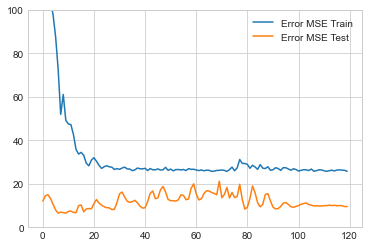

In [293]:
PlotMSE(train_hist_conf, test_hist_conf)

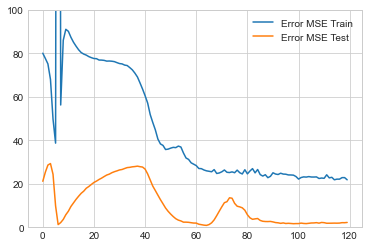

In [294]:
PlotMSE(train_hist_dead, test_hist_dead)

In [295]:
def Predecir(modelo, Xtest, dias_futuros = 15):
    with torch.no_grad():
        test_seq = Xtest[:1]
        preds = []
        for _ in range(dias_futuros):
            y_test_pred = modelo(test_seq)
            pred = torch.flatten(y_test_pred).item()
            preds.append(pred)
            new_seq = test_seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
    return preds

In [296]:
def BusquedaParametros():
    num_layers = range(1,4)
    #num_features = range(500, 1001,500)
    sequence_size = range(5,16,5)
    test_size = np.arange(0.5,1.0,0.1)
    arr_mse = np.empty( (len(sequence_size), len(num_layers)))
    for test in test_size:
      #Creando test train data
      print ("##############")
      print ("Test size: ", test)
      print ("##############")
      train_conf, test_conf = train_test_split(confNormalizado, test_size=test,shuffle=False)
      for sequence in range(0, len(sequence_size)):
        #Creando Secuencias
        X_train, y_train = CrearSecuencias(train_conf, sequence)
        X_test, y_test = CrearSecuencias(test_conf, sequence)
        for layers in range(0, len(num_layers)):
          model = CoronaVirusPredictor(n_features=1, n_hidden=512, seq_len=sequence_size[sequence], n_layers=num_layers[layers])
          model, train_hist, test_hist = Train_model(model, X_train, y_train, X_test, y_test, num_epochs= 120)

          arr_mse[sequence,layers] = test_hist[-1]
    print(pd.DataFrame(arr_mse, index = sequence_size, columns = num_layers))




In [297]:
def PreparacionDatosGrafica(preds, test, Data, scaler, futuro = 15):
    true_cases = DesNormalizar(test.flatten().numpy(), scaler)
    predicted_cases = DesNormalizar(preds, scaler)
    future_index = pd.date_range(start=Data.index[-7], periods= futuro+1, closed='left')
    future_cases = pd.Series(data=predicted_cases[-(futuro+1):], index=future_index)
    return true_cases, predicted_cases, future_cases

In [298]:
futuro = 15
preds_conf = Predecir(model_conf, X_test_conf, dias_futuros= len(X_test_conf) + futuro)
preds_dead = Predecir(model_dead, X_test_dead, dias_futuros= len(X_test_dead) + futuro)

In [299]:
true_cases_conf, predicted_cases_conf, future_cases_conf = PreparacionDatosGrafica(preds_conf, y_test_conf, confData, confScaler)
true_cases_dead, predicted_cases_dead, future_cases_dead = PreparacionDatosGrafica(preds_dead, y_test_dead, deadData, deadScaler)

In [300]:
def PloteoPrediccion(data, train, predicted, true, scaler, future_cases):
  diarios = pd.Series(data = scaler.inverse_transform(train).flatten(), index = data.index[:len(train)])
  reales = pd.Series(data = true, index = data.index[len(train):len(train) + len(true)] )
  predecidos = pd.Series(data = predicted[:-(futuro)], index = data.index[len(train):len(train) + len(true)] )
  #plt.plot(data.index[:len(train)], scaler.inverse_transform(train).flatten(), label='Historico de Casos diarios' )
  plt.plot(diarios, label='Historico de Casos diarios' )
  #plt.plot(data.index[len(train):len(train) + len(true)], true, label='Casos diarios reales')
  plt.plot(reales, label='Casos diarios reales')
  #plt.plot(data.index[len(train):len(train) + len(true)], predicted[:-futuro], label='Casos diarios predecidos' )
  plt.plot(predecidos, label='Casos diarios predecidos')
  plt.plot(future_cases, label='Casos diarios predecidos futuros' )

  plt.xticks(fontsize = 10, rotation=90)
  plt.tight_layout()
  plt.legend()

In [301]:
#PloteoPrediccion(deadregion, train_dead, predicted_cases_dead, true_cases_dead, future_cases_dead)

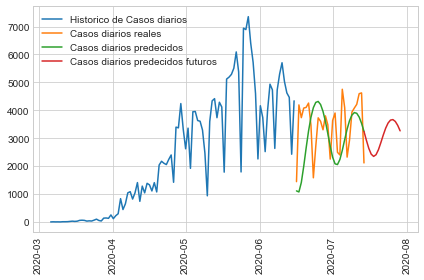

In [302]:
PloteoPrediccion(confData, train_conf, predicted_cases_conf, true_cases_conf, confScaler, future_cases_conf)

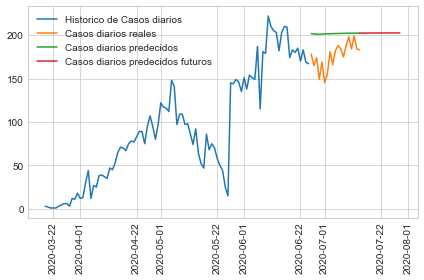

In [303]:
PloteoPrediccion(deadData, train_dead, predicted_cases_dead, true_cases_dead, deadScaler, future_cases_dead)

In [304]:
future_cases_dead

2020-07-14    202.306790
2020-07-15    202.335988
2020-07-16    202.361741
2020-07-17    202.384414
2020-07-18    202.404419
2020-07-19    202.422044
2020-07-20    202.437592
2020-07-21    202.451265
2020-07-22    202.463329
2020-07-23    202.473962
2020-07-24    202.483334
2020-07-25    202.491579
2020-07-26    202.498843
2020-07-27    202.505260
2020-07-28    202.510907
2020-07-29    202.515877
Freq: D, dtype: float64

In [305]:
def PrediccionRegiones(region: "", futuro = 15):
    confregion = DataRegion(region, 'positivo')
    deadregion = DataRegion(region, 'fallecido')
    #Creando variables para Modelo
    confScaler_region = Normalizar(confregion, 'CasosConfirmados')
    deadScaler_region = Normalizar(deadregion, 'Fallecidos')

    confNormal_region = confScaler_region.transform(confregion)
    deadNormal_region = deadScaler_region.transform(deadregion)
    #Crear subconjuntos train y test
    train_conf, test_conf = train_test_split(confNormal_region, test_size=.10, shuffle=False)
    train_dead, test_dead = train_test_split(deadNormal_region, test_size=.10, shuffle=False)
    
    X_train_conf, y_train_conf = CrearSecuencias(train_conf, seq_length)
    X_test_conf, y_test_conf = CrearSecuencias(test_conf, seq_length)
    #Secuencias para Fallecidos
    X_train_dead, y_train_dead = CrearSecuencias(train_dead, seq_length)
    X_test_dead, y_test_dead = CrearSecuencias(test_dead, seq_length)
    preds_conf = Predecir(model_conf, X_test_conf, dias_futuros= len(X_test_conf) + futuro)
    preds_dead = Predecir(model_dead, X_test_dead, dias_futuros= len(X_test_dead) + futuro)
    #print(preds_conf)

    true_cases_conf, predicted_cases_conf, future_cases_conf = PreparacionDatosGrafica(preds_conf, y_test_conf, confregion, confScaler_region, futuro)
    true_cases_dead, predicted_cases_dead, future_cases_dead = PreparacionDatosGrafica(preds_dead, y_test_dead, deadregion, deadScaler_region, futuro)
    PloteoPrediccion(confregion, train_conf, predicted_cases_conf, true_cases_conf, confScaler_region, future_cases_conf)
    plt.figure()
    PloteoPrediccion(deadregion, train_dead, predicted_cases_dead, true_cases_dead, deadScaler_region, future_cases_dead)
    #print(deadregion)
    return future_cases_conf, future_cases_dead

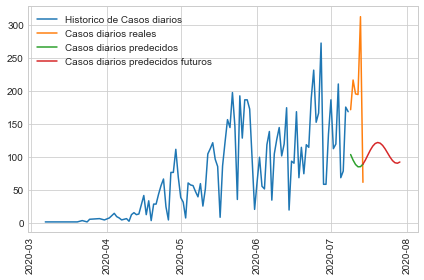

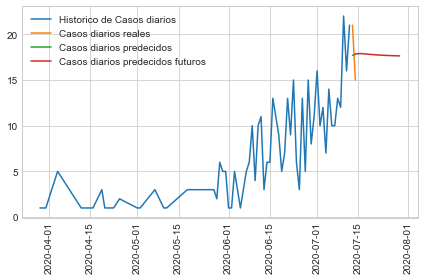

In [306]:
casos_aqp, dead_aqp = PrediccionRegiones("AREQUIPA")

In [307]:
casos_aqp

2020-07-14     88.465861
2020-07-15     94.811788
2020-07-16    102.379200
2020-07-17    109.777738
2020-07-18    115.861793
2020-07-19    119.852520
2020-07-20    121.347993
2020-07-21    120.284667
2020-07-22    116.898597
2020-07-23    111.704476
2020-07-24    105.478445
2020-07-25     99.206312
2020-07-26     93.956291
2020-07-27     90.668803
2020-07-28     89.919080
2020-07-29     91.756554
Freq: D, dtype: float64

In [308]:
dead_aqp

2020-07-14    17.828180
2020-07-15    17.884314
2020-07-16    17.885487
2020-07-17    17.862003
2020-07-18    17.831225
2020-07-19    17.801027
2020-07-20    17.773989
2020-07-21    17.750325
2020-07-22    17.729529
2020-07-23    17.711064
2020-07-24    17.694550
2020-07-25    17.679754
2020-07-26    17.666517
2020-07-27    17.654716
2020-07-28    17.644231
2020-07-29    17.634939
Freq: D, dtype: float64

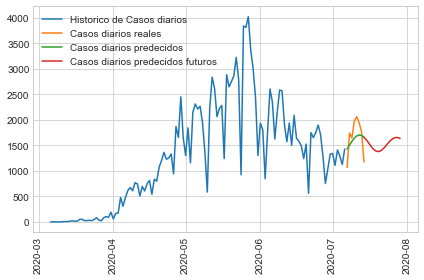

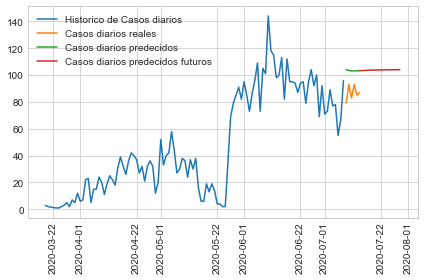

In [309]:
casos_lima, dead_lima = PrediccionRegiones("LIMA")

In [310]:
casos_lima

2020-07-14    1660.023814
2020-07-15    1607.109572
2020-07-16    1543.069353
2020-07-17    1478.123160
2020-07-18    1423.192707
2020-07-19    1387.847884
2020-07-20    1378.081629
2020-07-21    1394.786069
2020-07-22    1433.640282
2020-07-23    1486.448216
2020-07-24    1543.288600
2020-07-25    1594.633435
2020-07-26    1632.866093
2020-07-27    1653.067074
2020-07-28    1653.235664
2020-07-29    1634.199647
Freq: D, dtype: float64

In [311]:
dead_lima

2020-07-14    103.283596
2020-07-15    103.381835
2020-07-16    103.470234
2020-07-17    103.547775
2020-07-18    103.616082
2020-07-19    103.676871
2020-07-20    103.731332
2020-07-21    103.780166
2020-07-22    103.823830
2020-07-23    103.862714
2020-07-24    103.897219
2020-07-25    103.927730
2020-07-26    103.954677
2020-07-27    103.978447
2020-07-28    103.999408
2020-07-29    104.017884
Freq: D, dtype: float64